In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import Xception

from imgaug import augmenters 

In [3]:
train_path = './cnn/pneumonia_revamped/chest_xray/train'
test_path = './cnn/pneumonia_revamped/chest_xray/test/'
valid_path = './cnn/pneumonia_revamped/chest_xray/val/'

In [4]:
batch_size = 32

img_height = 75
img_width = 75

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


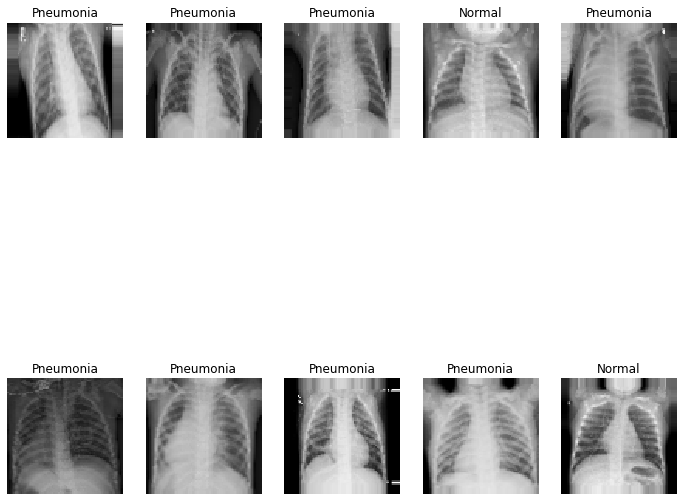

In [7]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [8]:
expert_conv = Xception(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [9]:
expert_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,132,073
Trainable params: 21,077,545
Non-trainable params: 54,528
_______________________________________

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(expert_model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [12]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


C:\Users\vishw\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:
expert_model.fit(train,epochs=12,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/12
163/163 [==============================] - 63s 386ms/step - loss: 0.6788 - accuracy: 0.5769 - val_loss: 0.6437 - val_accuracy: 0.5625
Epoch 2/12
163/163 [==============================] - 63s 388ms/step - loss: 0.5720 - accuracy: 0.7044 - val_loss: 0.5599 - val_accuracy: 0.6875
Epoch 3/12
163/163 [==============================] - 65s 397ms/step - loss: 0.4959 - accuracy: 0.8290 - val_loss: 0.4826 - val_accuracy: 0.8750
Epoch 4/12
163/163 [==============================] - 64s 395ms/step - loss: 0.4448 - accuracy: 0.8786 - val_loss: 0.4762 - val_accuracy: 0.8750
Epoch 5/12
163/163 [==============================] - 61s 375ms/step - loss: 0.4019 - accuracy: 0.9036 - val_loss: 0.4477 - val_accuracy: 0.8750
Epoch 6/12
163/163 [==============================] - 62s 380ms/step - loss: 0.3754 - accuracy: 0.9114 - val_loss: 0.4239 - val_accuracy: 0.8750
Epoch 7/12
163/163 [==============================] - 62s 379ms/step - loss: 0.3435 - accuracy: 0.9206 - val_loss: 0.5530 - val_ac

<AxesSubplot:>

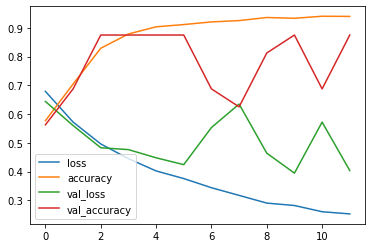

In [14]:
pd.DataFrame(expert_model.history.history).plot()

In [15]:
test_accu = expert_model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 5s 269ms/step - loss: 0.3690 - accuracy: 0.8926
The testing accuracy is -  89.26281929016113 %


## Evaluate

In [16]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [17]:
y_bar = np.round(expert_model.predict(test)).reshape(-1)
y_act = test.labels

In [18]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.8926282051282052
ROC-AUC score:  0.8862066686494168
F1 score:  0.9144316730523626
Log Loss:  3.7085314191935614
